In [1]:
import pickle
import sys
from zoneinfo import ZoneInfo
sys.path.append("../")

from dotenv import load_dotenv
load_dotenv()
import geopandas as gpd
import importlib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import lightning.pytorch as pl
import rasterio as rio
from rasterio.plot import show
import seaborn as sns
import shapely
import statsmodels.api as sm
import torch
from torch.utils.data import DataLoader

from openbustools import plotting, spatial, standardfeeds
from openbustools.traveltime import data_loader, model_utils
from openbustools.drivecycle import trajectory
from openbustools.drivecycle.physics import conditions, energy, vehicle

from srai.embedders import GTFS2VecEmbedder
from srai.joiners import IntersectionJoiner
from srai.loaders import GTFSLoader
from srai.loaders.osm_loaders.filters import HEX2VEC_FILTER
from srai.neighbourhoods.h3_neighbourhood import H3Neighbourhood
from srai.regionalizers import H3Regionalizer, geocode_to_region_gdf
from srai.plotting import plot_regions, plot_numeric_data

In [5]:
if torch.cuda.is_available():
    num_workers=4
    pin_memory=True
    accelerator="cuda"
else:
    num_workers=0
    pin_memory=False
    accelerator="cpu"

logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.ERROR)

model_network = "kcm"
model_type = "GRU"

train_days = standardfeeds.get_date_list('2024_01_05', 1)
train_days = [x.split(".")[0] for x in train_days]
test_days = standardfeeds.get_date_list('2024_02_06', 7)
test_days = [x.split(".")[0] for x in test_days]

cleaned_sources = pd.read_csv(Path('..', 'data', 'cleaned_sources.csv'))

In [4]:
# Test model on each city
res = {}
test_sources = cleaned_sources.iloc[:]
for i, row in test_sources.iterrows():
    # Load model and check if day has data for given city
    model = model_utils.load_model("../logs/", model_network, model_type, 0)
    model.eval()
    test_data_folders = [f"../data/other_feeds/{row['uuid']}_realtime/processed"]
    available_days = [x.name for x in Path(test_data_folders[0], "training").glob('*')]
    if test_days[0] not in available_days:
        continue
    # Run inference for city
    print(row['provider'])
    test_dataset = data_loader.NumpyDataset(
        test_data_folders,
        test_days,
        holdout_routes=model.holdout_routes,
        load_in_memory=True,
        config = model.config,
    )
    test_loader = DataLoader(
        test_dataset,
        collate_fn=model.collate_fn,
        batch_size=model.batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    trainer = pl.Trainer(
        accelerator=accelerator,
        logger=False,
        inference_mode=True
    )
    preds_and_labels = trainer.predict(model=model, dataloaders=test_loader)
    preds = np.concatenate([x['preds'] for x in preds_and_labels])
    labels = np.concatenate([x['labels'] for x in preds_and_labels])
    res[row['uuid']] = {'preds':preds, 'labels':labels}

London Transit Commission


Predicting: |          | 0/? [00:00<?, ?it/s]

Barrie Transit


Predicting: |          | 0/? [00:00<?, ?it/s]

Big Blue Bus


Predicting: |          | 0/? [00:00<?, ?it/s]

Mountain View Transportation Management Association (MVgo)


Predicting: |          | 0/? [00:00<?, ?it/s]

Capital Metro


Predicting: |          | 0/? [00:00<?, ?it/s]

Regional Transportation District (RTD)


Predicting: |          | 0/? [00:00<?, ?it/s]

Metro St. Louis


Predicting: |          | 0/? [00:00<?, ?it/s]

Intercity Transit


Predicting: |          | 0/? [00:00<?, ?it/s]

Duluth Transit


Predicting: |          | 0/? [00:00<?, ?it/s]

Votran


Predicting: |          | 0/? [00:00<?, ?it/s]

Nashville Metropolitan Transit Authority (Nashville MTA)


Predicting: |          | 0/? [00:00<?, ?it/s]

Transit Authority of River City (TARC)


Predicting: |          | 0/? [00:00<?, ?it/s]

Metropolitan Atlanta Rapid Transit Authority (MARTA)


Predicting: |          | 0/? [00:00<?, ?it/s]

Springfield Mass Transit District (SMTD)


Predicting: |          | 0/? [00:00<?, ?it/s]

Metro Transit


Predicting: |          | 0/? [00:00<?, ?it/s]

Port Authority of Allegheny County


Predicting: |          | 0/? [00:00<?, ?it/s]

Massachusetts Bay Transportation Authority (MBTA)


Predicting: |          | 0/? [00:00<?, ?it/s]

Arlington Transit


Predicting: |          | 0/? [00:00<?, ?it/s]

Rochester-Genesee Regional Transportation Authority (RGRTA)


Predicting: |          | 0/? [00:00<?, ?it/s]

BC Transit (Victoria Regional Transit System)


Predicting: |          | 0/? [00:00<?, ?it/s]

Edmonton Transit System


Predicting: |          | 0/? [00:00<?, ?it/s]

Saskatoon Transit


Predicting: |          | 0/? [00:00<?, ?it/s]

Hamilton Street Railway


Predicting: |          | 0/? [00:00<?, ?it/s]

MiWay


Predicting: |          | 0/? [00:00<?, ?it/s]

Kingston Transit


Predicting: |          | 0/? [00:00<?, ?it/s]

Halifax Transit


Predicting: |          | 0/? [00:00<?, ?it/s]

Thunder Bay Transit


Predicting: |          | 0/? [00:00<?, ?it/s]

Port Alberni


Predicting: |          | 0/? [00:00<?, ?it/s]

Commerce Municipal Bus Lines


Predicting: |          | 0/? [00:00<?, ?it/s]

Stanislaus Regional Transit Authority (StanRTA)


Predicting: |          | 0/? [00:00<?, ?it/s]

In [10]:
save_dir = Path("..", "results", model_network, "multicity_tuning")
save_dir.mkdir(parents=True, exist_ok=True)
with open(save_dir / f"{model_type}.pkl", "wb") as f:
    pickle.dump(res, f)

In [11]:
# Tune, then re-test
n_batches = 1
res_tuned = {}
test_sources = cleaned_sources.iloc[:]
for i, row in test_sources.iterrows():
    # Load model and check if day has data for given city
    data_folders = [f"../data/other_feeds/{row['uuid']}_realtime/processed"]
    available_days = [x.name for x in Path(data_folders[0], "training").glob('*')]
    if train_days[0] not in available_days:
        continue
    print(row['provider'])
    res_tuned[row['uuid']] = {}
    # Try increasing amounts of training samples per-city
    model = model_utils.load_model("../logs/", model_network, model_type, 0)
    model.eval()
    train_dataset = data_loader.NumpyDataset(
        data_folders,
        train_days,
        load_in_memory=True,
        config = model.config
    )
    train_loader = DataLoader(
        train_dataset,
        collate_fn=model.collate_fn,
        batch_size=model.batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    trainer = pl.Trainer(
        max_epochs=10,
        limit_train_batches=n_batches,
        accelerator=accelerator
    )
    trainer.fit(model=model, train_dataloaders=train_loader)
    # Test after fine-tuning
    test_dataset = data_loader.NumpyDataset(
        data_folders,
        test_days,
        load_in_memory=True,
        config = model.config
    )
    train_loader = DataLoader(
        train_dataset,
        collate_fn=model.collate_fn,
        batch_size=model.batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    trainer = pl.Trainer(
        accelerator=accelerator,
        logger=False,
        inference_mode=True
    )
    preds_and_labels = trainer.predict(model=model, dataloaders=test_loader)
    preds = np.concatenate([x['preds'] for x in preds_and_labels])
    labels = np.concatenate([x['labels'] for x in preds_and_labels])
    res_tuned[row['uuid']][f"{n_batches}_batches"] = {'preds':preds, 'labels':labels}

London Transit Commission


/home/zack/Desktop/open_bus_tools/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: /home/zack/Desktop/open_bus_tools/notebooks/lightning_logs

  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)
/home/zack/Desktop/open_bus_tools/.venv/lib/pyt

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Barrie Transit



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Big Blue Bus


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Mountain View Transportation Management Association (MVgo)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Capital Metro


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Regional Transportation District (RTD)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Metro St. Louis



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Intercity Transit


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Duluth Transit


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Votran


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Nashville Metropolitan Transit Authority (Nashville MTA)



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Transit Authority of River City (TARC)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Metropolitan Atlanta Rapid Transit Authority (MARTA)



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Springfield Mass Transit District (SMTD)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Metro Transit


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Port Authority of Allegheny County



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Massachusetts Bay Transportation Authority (MBTA)



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Arlington Transit


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Rochester-Genesee Regional Transportation Authority (RGRTA)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Adelaide Metro



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


TransLink Sunbus Cairns


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

BC Transit (Victoria Regional Transit System)



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Edmonton Transit System



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Saskatoon Transit



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Hamilton Street Railway



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

MiWay



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Kingston Transit


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Halifax Transit



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Thunder Bay Transit


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Port Alberni


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Commerce Municipal Bus Lines


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Roma Servizi per la Mobilità



  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


  | Name                       | Type            | Params
---------------------------------------------------------------
0 | loss_fn                    | MSELoss         | 0     
1 | min_em                     | MinuteEmbedding | 69.1 K
2 | day_em                     | DayEmbedding    | 28    
3 | rnn                        | GRU             | 38.6 K
4 | feature_extract            | Linear          | 117   
5 | feature_extract_activation | ReLU            | 0     
---------------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.431     Total estimated model params size (MB)


Stanislaus Regional Transit Authority (StanRTA)


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [12]:
save_dir = Path("..", "results", model_network, "multicity_tuning")
save_dir.mkdir(parents=True, exist_ok=True)
with open(save_dir / f"{model_type}_TUNED_{n_batches}.pkl", "wb") as f:
    pickle.dump(res_tuned, f)

In [13]:
metrics = {}
for key, value in res.items():
    metrics[key] = model_utils.performance_metrics(value['labels'], value['preds'])
metrics_df = pd.DataFrame(metrics).T
metrics_df.index.name = 'uuid'
metrics_df = metrics_df.reset_index()
metrics_df = pd.merge(metrics_df, cleaned_sources, on='uuid')
metrics_df['experiment'] = 'not-tuned'
metrics_df['n_batches'] = '0_batches'
metrics_df[['provider','n_batches','experiment','mae', 'mape', 'rmse', 'ex_var', 'r_score']].sort_values(['provider', 'n_batches']).head(10)

,provider,n_batches,experiment,mae,mape,rmse,ex_var,r_score
17,Arlington Transit,0_batches,not-tuned,65.444176,0.169666,8.089758,0.897595,0.883940
19,BC Transit (Victoria Regional Transit System),0_batches,not-tuned,63.073997,0.133397,7.941914,0.938010,0.937397
1,Barrie Transit,0_batches,not-tuned,188.785934,0.247436,13.739940,0.862307,0.695257
2,Big Blue Bus,0_batches,not-tuned,391.352905,0.439688,19.782642,0.784724,0.352333
4,Capital Metro,0_batches,not-tuned,124.948387,0.155420,11.178032,0.941106,0.938324
28,Commerce Municipal Bus Lines,0_batches,not-tuned,188.270676,0.167360,13.721176,0.880944,0.803108
8,Duluth Transit,0_batches,not-tuned,104.540520,0.198683,10.224505,0.879514,0.876030
20,Edmonton Transit System,0_batches,not-tuned,285.925293,0.462649,16.909327,0.655285,0.302092
25,Halifax Transit,0_batches,not-tuned,103.134399,0.148644,10.155511,0.908909,0.907816
22,Hamilton Street Railway,0_batches,not-tuned,119.839798,0.174440,10.947137,0.897009,0.887952


In [14]:
metrics = {}
for k_uuid, res_uuid in res_tuned.items():
    for k_n_batches, res_n_batches in res_uuid.items():
        metrics[(k_uuid, k_n_batches)] = model_utils.performance_metrics(res_n_batches['labels'], res_n_batches['preds'])
metrics_tuned_df = pd.DataFrame(metrics).T
metrics_tuned_df.index.names = ['uuid', 'n_batches']
metrics_tuned_df = metrics_tuned_df.reset_index()
metrics_tuned_df = pd.merge(metrics_tuned_df, cleaned_sources, on='uuid')
metrics_tuned_df['experiment'] = 'tuned'
metrics_tuned_df[['provider','n_batches','experiment','mae', 'mape', 'rmse', 'ex_var', 'r_score']].sort_values(['provider', 'n_batches']).head(10)

,provider,n_batches,experiment,mae,mape,rmse,ex_var,r_score
19,Adelaide Metro,1_batches,tuned,122.660835,0.140794,11.075235,0.789250,0.784115
17,Arlington Transit,1_batches,tuned,101.352539,0.121102,10.067400,0.913611,0.913501
21,BC Transit (Victoria Regional Transit System),1_batches,tuned,168.292358,0.196101,12.972754,0.807387,0.733422
1,Barrie Transit,1_batches,tuned,108.237457,0.128218,10.403724,0.892388,0.884676
2,Big Blue Bus,1_batches,tuned,269.800171,0.287338,16.425594,0.163373,-0.085905
4,Capital Metro,1_batches,tuned,108.740150,0.133437,10.427855,0.915396,0.904870
30,Commerce Municipal Bus Lines,1_batches,tuned,89.836754,0.111055,9.478226,0.940138,0.940069
8,Duluth Transit,1_batches,tuned,138.685211,0.165998,11.776468,0.879034,0.839307
22,Edmonton Transit System,1_batches,tuned,117.479424,0.136586,10.838793,0.892474,0.882070
27,Halifax Transit,1_batches,tuned,167.348801,0.204512,12.936337,0.905454,0.825614


<Axes: xlabel='MAPE', ylabel='Count'>

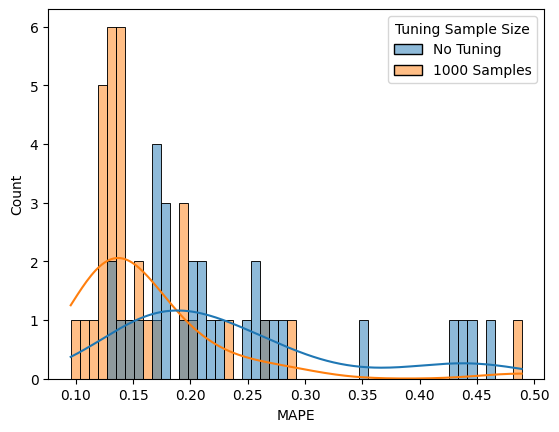

In [15]:
plot_df = pd.concat([metrics_df, metrics_tuned_df], axis=0)
plot_df = plot_df[plot_df['n_batches'].isin(['0_batches', '1_batches', '2_batches', '4_batches'])]
plot_df['Tuning Sample Size'] = plot_df['n_batches'].replace({'0_batches': 'No Tuning', '1_batches': '1000 Samples', '2_batches': '2000 Samples', '4_batches': '4000 Samples'})
plot_df['MAPE'] = plot_df['mape']
sns.histplot(plot_df, x='MAPE', hue='Tuning Sample Size', bins=50, kde=True)